# Complete EDA for Loan Prediction
***
***

__[Analysis by :: Ankit Bhatia](https://www.linkedin.com/in/ab9bhatia/)__

### <u>Table of Contents</u>
[I. Prerequisite](#prerequisite)

[II. Import Libraries and set required parameters](#library)

![](http://)[III. Data Sourcing](#sourcing)

[IV. Data Cleaning and Manipulation](#cleaning)

[V. Derived Metrics](#derived)

[VI. Univariate Analysis](#univariate)

[VII. Bivariate/Multivariate Analysis](#bivariate)

[VII. Bivariate/Multivariate Analysis with Probability of Charged off](#bivariate_prob)

[IX. Conclusion](#Conclusion)

<a id='prerequisite'></a>

## I. Prerequisite

1. Place 'loan.csv' input file at __"../input"__ directory before running this code.

2. Please make sure that you have following python libraries imported/installed at your system:

    * numpy version	: 1.12.1 or higher
    * pandas version	: 0.20.3 or higher
    * seaborn version	: 0.8.0 or higher

<a id='library'></a>

## II. Import Libraries and set required parameters

In [1]:
import numpy as np
print('numpy version\t:',np.__version__)
import pandas as pd
print('pandas version\t:',pd.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

# Regular expressions
import re

# seaborn : advanced visualization
import seaborn as sns
print('seaborn version\t:',sns.__version__)

pd.options.mode.chained_assignment = None #set it to None to remove SettingWithCopyWarning
pd.options.display.float_format = '{:.4f}'.format #set it to convert scientific noations such as 4.225108e+11 to 422510842796.00
pd.set_option('display.max_columns', 100) # to display all the columns

np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})

import os

import warnings
warnings.filterwarnings('ignore') # if there are any warning due to version mismatch, it will be ignored

numpy version	: 1.16.2
pandas version	: 0.24.2
seaborn version	: 0.9.0


<a id='sourcing'></a>

## III. Data Sourcing

In [2]:
print(os.listdir("../input"))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../input'

In [2]:
loan = pd.read_csv('data.csv',dtype='object')
print(loan.shape)

(855969, 73)


#### Get some insights

In [4]:
loan.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_ind
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000,Verified,Dec-11,n,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.7,9,f,0,0,5861.071414,5831.78,5000,861.07,0,0,0,Jan-15,171.62,NaN,Jan-16,0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000,Source Verified,Dec-11,n,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1,0,Apr-99,5,NaN,NaN,3,0,1687,9.4,4,f,0,0,1008.71,1008.71,456.46,435.17,0,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


__List of Columns & NA counts where NA values are more than 30%__

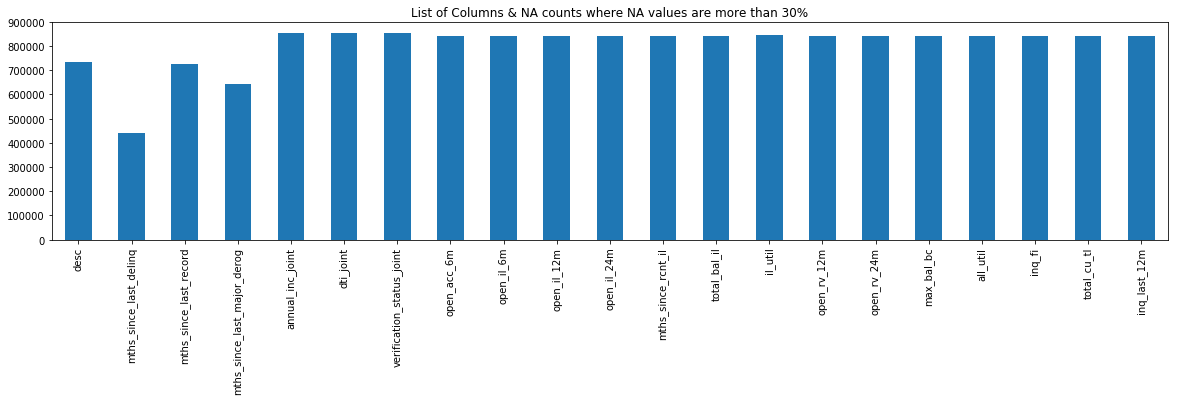

In [7]:
NA_col = loan.isnull().sum()
NA_col = NA_col[NA_col.values >(0.3*len(loan))]
plt.figure(figsize=(20,4))
NA_col.plot(kind='bar')
plt.title('List of Columns & NA counts where NA values are more than 30%')
plt.show()

<font color='blue'><b>Insights</b>: So we can see from the above plot that there are 20+ columns in the dataset where all the values are NA.</font> 

As we can see there are <b>887379</b> rows & <b>74</b> columns in the dataset, it will be very difficult to look at each column one by one & find the NA or missing values.
So let's find out all columns where missing values are more than certain percentage, let's say <b>30%</b>. We will remove those columns as it is not feasable to impute missing values for those columns.

We will create a UDF for this.

<a id='cleaning'></a>

## IV. Data Cleaning and Manipulation

__<font color='green'>UDF :: removeNulls(dataframe, axis, percent)</font>__

###### removeNulls(dataframe, axis, percent) will drop the columns/rows from the dataset based on the parameter values.

In [8]:
def removeNulls(dataframe, axis =1, percent=0.3):
    '''
    * removeNull function will remove the rows and columns based on parameters provided.
    * dataframe : Name of the dataframe  
    * axis      : axis = 0 defines drop rows, axis =1(default) defines drop columns    
    * percent   : percent of data where column/rows values are null,default is 0.3(30%)
              
    '''
    df = dataframe.copy()
    ishape = df.shape
    if axis == 0:
        rownames = df.transpose().isnull().sum()
        rownames = list(rownames[rownames.values > percent*len(df)].index)
        df.drop(df.index[rownames],inplace=True) 
        print("\nNumber of Rows dropped\t: ",len(rownames))
    else:
        colnames = (df.isnull().sum()/len(df))
        colnames = list(colnames[colnames.values>=percent].index)
        df.drop(labels = colnames,axis =1,inplace=True)        
        print("Number of Columns dropped\t: ",len(colnames))
        
    print("\nOld dataset rows,columns",ishape,"\nNew dataset rows,columns",df.shape)

    return df

#### 1. Remove columns where NA values are more than or equal to 30%

In [9]:
loan = removeNulls(loan, axis =1,percent = 0.3)

Number of Columns dropped	:  21

Old dataset rows,columns (855969, 73) 
New dataset rows,columns (855969, 52)


#### 2. Remove rows where NA values are more than or equal to 30%
(Note: NA columns has already been removed in step 1, so we may not find any <b>rows</b> where 30% values are NA)

In [8]:
loan = removeNulls(loan, axis =0,percent = 0.3)

There are no rows where NA values are more than or equal to 30%

#### 3. Remove columns where number of unique value is only 1.

Let's look at no of unique values for each column.We will remove all columns where number of unique value is only 1 because that will not make any sense in the analysis

In [9]:
unique = loan.nunique()
unique = unique[unique.values == 1]

In [10]:
loan.drop(labels = list(unique.index), axis =1, inplace=True)
print("So now we are left with",loan.shape ,"rows & columns.")

#### 4. Employment Term : Remove 'n/a' value with 'self-employed'.

There are some values in emp_term which are <b>'n/a'</b>, we assume that are <b>'self-employed'</b>. Because for 'self-employed' applicants, emp-lenth is 'Not Applicable'

In [11]:
print(loan.emp_length.unique())
loan.emp_length.fillna('0',inplace=True)
loan.emp_length.replace(['n/a'],'Self-Employed',inplace=True)
print(loan.emp_length.unique())

#### 5. Remove irrelevant columns.

Till now we have removed the columns based on the count & statistics.
Now let's look at each column from business perspective if that is required or not for our analysis such as Unique ID's, URL.
As last 2 digits of zip code is masked 'xx', we can remove that as well.

In [12]:
not_required_columns = ["id","member_id","url","zip_code"]
loan.drop(labels = not_required_columns, axis =1, inplace=True)
print("So now we are left with",loan.shape ,"rows & columns.")

#### 6. Cast all continuos variables to numeric
Cast all continuos variables to numeric so that we can find a correlation between them

In [13]:
numeric_columns = ['loan_amnt','funded_amnt','funded_amnt_inv','installment','int_rate','annual_inc','dti']

loan[numeric_columns] = loan[numeric_columns].apply(pd.to_numeric)

In [14]:
loan.tail(3)

#### 7. Purpose of loan : Drop records where values are less than 0.75%
We will analyse only those categories which contain more than 0.75% of records.
Also, we are not aware what comes under 'Other' we will remove this category as well.

In [15]:
(loan.purpose.value_counts()*100)/len(loan)

In [16]:
del_loan_purpose = (loan.purpose.value_counts()*100)/len(loan)
del_loan_purpose = del_loan_purpose[(del_loan_purpose < 0.75) | (del_loan_purpose.index == 'other')]

loan.drop(labels = loan[loan.purpose.isin(del_loan_purpose.index)].index, inplace=True)
print("So now we are left with",loan.shape ,"rows & columns.")

print(loan.purpose.unique())

#### 8. Loan Status : Drop records where values are less than 1.5%
As we can see, Other than ['Current','Fully Paid' & Charged off] other loan_status are not relevent for our analysis.

In [17]:
(loan.loan_status.value_counts()*100)/len(loan)

In [18]:
del_loan_status = (loan.loan_status.value_counts()*100)/len(loan)
del_loan_status = del_loan_status[(del_loan_status < 1.5)]

loan.drop(labels = loan[loan.loan_status.isin(del_loan_status.index)].index, inplace=True)
print("So now we are left with",loan.shape ,"rows & columns.")

print(loan.loan_status.unique())

<a id='derived'></a>

## V. Derived Metrics

** We will now derive some new columns based on our business understanding that will be helpful in our analysis. **

#### 1. Loan amount to Annual Income ratio

In [19]:
loan['loan_income_ratio']= loan['loan_amnt']/loan['annual_inc']

#### 2. Extract Year & Month from Issue date

In [3]:
loan['issue_month'],loan['issue_year'] = loan['issue_d'].str.split('-', 1).str
loan[['issue_d','issue_month','issue_year']].head()

,issue_d,issue_month,issue_year
0,Dec-11,Dec,11
1,Dec-11,Dec,11
2,Dec-11,Dec,11
3,Dec-11,Dec,11
4,Dec-11,Dec,11


#### 3. Change order of months from Jan to Dec, currently it's in alphabetical order(A-Z)

In [4]:
months_order = ["Jan", "Feb", "Mar", "Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
loan['issue_month'] = pd.Categorical(loan['issue_month'],categories=months_order, ordered=True)

#### 4. Create Bins for range of Loan Amount

In [22]:
bins = [0, 5000, 10000, 15000, 20000, 25000,40000]
slot = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000','25000 and above']
loan['loan_amnt_range'] = pd.cut(loan['loan_amnt'], bins, labels=slot)

#### 5. Create Bins for range of Annual Income

In [23]:
bins = [0, 25000, 50000, 75000, 100000,1000000]
slot = ['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000 and above']
loan['annual_inc_range'] = pd.cut(loan['annual_inc'], bins, labels=slot)

#### 6. Create Bins for range of Interest rates

In [24]:
bins = [0, 7.5, 10, 12.5, 15,20]
slot = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15 and above']
loan['int_rate_range'] = pd.cut(loan['int_rate'], bins, labels=slot)

<a id='univariate'></a>

## VI. Univariate Analysis

### Continuous Variables
In case of continuous variables, we need to understand the central tendency and spread of the variable.These are measured using various statistical metrics visualization methods such as Boxplot,Histogram/Distribution Plot, Violin Plot etc.

### Categorical Variables
For categorical variables, we’ll use frequency table to understand distribution of each category. It can be be measured using two metrics, Count and Count% against each category. Countplot or Bar chart can be used as visualization.

__<font color='green'>UDF :: univariate(df,col,vartype,hue)</font>__

###### Univariate function will plot the graphs based on the parameter values.

In [25]:
def univariate(df,col,vartype,hue =None):
    
    '''
    Univariate function will plot the graphs based on the parameters.
    df      : dataframe name
    col     : Column name
    vartype : variable type : continuos or categorical
                Continuos(0)   : Distribution, Violin & Boxplot will be plotted.
                Categorical(1) : Countplot will be plotted.
    hue     : It's only applicable for categorical analysis.
    
    '''
    sns.set(style="darkgrid")
    
    if vartype == 0:
        fig, ax=plt.subplots(nrows =1,ncols=3,figsize=(20,8))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df[col],ax=ax[0])
        ax[1].set_title("Violin Plot")
        sns.violinplot(data =df, x=col,ax=ax[1], inner="quartile")
        ax[2].set_title("Box Plot")
        sns.boxplot(data =df, x=col,ax=ax[2],orient='v')
    
    if vartype == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
        width = len(df[col].unique()) + 6 + 4*len(temp.unique())
        fig.set_size_inches(width , 7)
        ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(loan))), (p.get_x()+0.05, p.get_height()+20))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
    else:
        exit
        
    plt.show()

### Continuous Variables

#### 1. Loan Amount

In [26]:
univariate(df=loan,col='loan_amnt',vartype=0)

<font color='blue'><b>Insights</b>: Most of the loan amounts are distributed between 8000 to 20000 USD.</font> 

#### 2. Interest Rate

In [27]:
univariate(df=loan,col='int_rate',vartype=0)

<font color='blue'><b>Insights</b>: Most of the loans interest rates are distributed between 10% to 16%.</font> 

#### 3. Annual Income

In [28]:
loan["annual_inc"].describe()

###### Max value is 9500000 which is approx 150 times more than mean value, so we will remove the outliers from Annual Income.

Remove Outliers (values from 99 to 100%)

In [29]:
q = loan["annual_inc"].quantile(0.995)
loan = loan[loan["annual_inc"] < q]
loan["annual_inc"].describe()

In [30]:
univariate(df=loan,col='annual_inc',vartype=0)

<font color='blue'><b>Insights</b>: Most of the applicants earns beteen 40000 to 90000 USD annually.</font> 

### Categorical Variables

#### 4. Loan Status

In [31]:
univariate(df=loan,col='loan_status',vartype=1)

<font color='blue'><b>Insights</b>: 5% of the applicants Charged off.</font> 

#### 5. Purpose of loan

In [32]:
univariate(df=loan,col='purpose',vartype=1,hue='loan_status')

<font color='blue'><b>Insights</b>: Approx 60% of the applicants applied loan for paying their other loans(Debt Consolidation).</font> 

#### 6. Home Ownership wise Loan

In [33]:
loan.home_ownership.unique()

In [34]:
# Remove rows where home_ownership'=='OTHER', 'NONE', 'ANY'
rem = ['OTHER', 'NONE', 'ANY']
loan.drop(loan[loan['home_ownership'].isin(rem)].index,inplace=True)
loan.home_ownership.unique()

In [35]:
univariate(df=loan,col='home_ownership',vartype=1,hue='loan_status')

<font color='blue'><b>Insights</b>: 40% of applicants are living in rented home whereas 52% applicants were mortagaged their home.</font> 

#### 7. Year wise Loan

In [36]:
year_wise =loan.groupby(by= [loan.issue_year])[['loan_status']].count()
year_wise.rename(columns={"loan_status": "count"},inplace=True)
ax =year_wise.plot(figsize=(20,8))
year_wise.plot(kind='bar',figsize=(20,8),ax = ax)
plt.show()

<font color='blue'><b>Insights</b>: loan applicants are increasing year on year, approx 47% of loan applicants received loans in 2011.</font> 

#### 8. Loan Term

In [37]:
univariate(df=loan,col='term',vartype=1,hue='loan_status')

<font color='blue'><b>Insights</b>: 70% of applicants applied loan for 36 months term period.</font> 

In [38]:
loan.head(3)

<a id='bivariate'></a>

## VII. Bivariate/Multivariate Analysis
Bivariate/Multivariate Analysis finds out the relationship between two/two or more variables.We can perform Bivariate/Multivariate analysis for any combination of categorical and continuous variables. The combination can be: Categorical & Categorical, Categorical & Continuous and Continuous & Continuous.

#### 1. Purpose of Loan vs Loan Amount for each Loan Status

In [39]:
plt.figure(figsize=(16,12))
sns.boxplot(data =loan, x='purpose', y='loan_amnt', hue ='loan_status')
plt.title('Purpose of Loan vs Loan Amount')
plt.show()

#### 2. Correlation Matrix : All Continuos(Numeric) Variables

In [40]:
loan_correlation = loan.corr()
loan_correlation

#### 3. HeatMap: All continuos variables

In [41]:
f, ax = plt.subplots(figsize=(14, 9))
sns.heatmap(loan_correlation, 
            xticklabels=loan_correlation.columns.values,
            yticklabels=loan_correlation.columns.values,annot= True)
plt.show()

<font color='blue'><b>Insights</b>: It is clear from the Heatmap that how <b>'loan_amnt','funded_amnt' & 'funded_amnt_inv'</b> are closely <b>interrelated</b>.So we can take any one column out of them for our analysis.</font> 

#### 4. Employment Length vs Loan Amount for different pupose of Loan

In [42]:
loanstatus=loan.pivot_table(index=['loan_status','purpose','emp_length'],values='loan_amnt',aggfunc=('count')).reset_index()
loanstatus=loan.loc[loan['loan_status']=='Charged Off']

In [43]:
ax = plt.figure(figsize=(30, 18))
ax = sns.boxplot(x='emp_length',y='loan_amnt',hue='purpose',data=loanstatus)
ax.set_title('Employment Length vs Loan Amount for different pupose of Loan',fontsize=22,weight="bold")
ax.set_xlabel('Employment Length',fontsize=16)
ax.set_ylabel('Loan Amount',color = 'b',fontsize=16)
plt.show()

<a id='bivariate_prob'></a>

## VIII. Bivariate/Multivariate Analysis with Probability of Charge off

### Categorical Variables vs Probability of Charged Off

The main motive of this use case to find what parameters are impacting the most on Loan Status that is if a applicant will successfully complete the loan term or will charge off.

So we will be using a new term now <b>Probability of Charged Off</b> that will be equal to :

\begin{equation*}
{Probability\:of\:Charged\:Off =\:}\frac{Number\:of\:Applicants\:who\:charged\:off}{Total\:No.\:of\:Applicants}
\end{equation*}


We will calculate this probability w.r.t each column in bivariate analysis & will see how the Probability of Charged Off changes with these columns.

We will create a user defined function for this.

__<font color='green'><u><b>UDF: </b>crosstab</u></font>__
##### 'crosstab' function will be used to get the summarized table for each column(passed as a variable) along with probability of charge off w.r.t that column.

In [44]:
def crosstab(df,col):
    '''
    df : Dataframe
    col: Column Name
    '''
    crosstab = pd.crosstab(df[col], df['loan_status'],margins=True)
    crosstab['Probability_Charged Off'] = round((crosstab['Charged Off']/crosstab['All']),3)
    crosstab = crosstab[0:-1]
    return crosstab

__<font color='green'><u><b>UDF: </b>bivariate_prob</u></font>__
##### 'bivariate_prob' function will be used to plot count of values for each column(passed as a variable) stacked across 'loan_status' along with probability of charged off as a line chart.

In [45]:
# Probability of charge off
def bivariate_prob(df,col,stacked= True):
    '''
    df      : Dataframe
    col     : Column Name
    stacked : True(default) for Stacked Bar
    '''
    # get dataframe from crosstab function
    plotCrosstab = crosstab(df,col)
    
    linePlot = plotCrosstab[['Probability_Charged Off']]      
    barPlot =  plotCrosstab.iloc[:,0:2]
    ax = linePlot.plot(figsize=(20,8), marker='o',color = 'b')
    ax2 = barPlot.plot(kind='bar',ax = ax,rot=1,secondary_y=True,stacked=stacked)
    ax.set_title(df[col].name.title()+' vs Probability Charge Off',fontsize=20,weight="bold")
    ax.set_xlabel(df[col].name.title(),fontsize=14)
    ax.set_ylabel('Probability of Charged off',color = 'b',fontsize=14)
    ax2.set_ylabel('Number of Applicants',color = 'g',fontsize=14)
    plt.show()

#### 1. Location vs Probability Charge Off

In [46]:
filter_states = loan.addr_state.value_counts()
filter_states = filter_states[(filter_states < 10)]

loan_filter_states = loan.drop(labels = loan[loan.addr_state.isin(filter_states.index)].index)

In [47]:
states = crosstab(loan_filter_states,'addr_state')
display(states.tail(20))

bivariate_prob(df =loan_filter_states,col ='addr_state')

<font color='blue'><b>Insights</b>: There are multiple States/Provinces with high probability of charge,highest being 'NV' at 7%</font>   

#### 2. Purpose of Loan vs Probability Charge Off

In [48]:
purpose = crosstab(loan,'purpose')
display(purpose)

bivariate_prob(df =loan,col ='purpose',stacked=False)

<font color='blue'><b>Insights</b>: Applicants who has taken the Loan for 'small business' has the highest probabilty of charge off of 14%. So bank should take extra caution like take some asset or guarentee while approving the loan for purpose of 'small business'</font>   

#### 3. Grade/Subgrade vs Probability Charge Off

In [49]:
grade = crosstab(loan,'grade')
display(grade)

bivariate_prob(df =loan,col ='grade',stacked=False)
bivariate_prob(df =loan,col ='sub_grade')

<font color='blue'><b>Insights</b>: As we move from Grade A to G, probability that person will charged off is increasing.</font>      

#### 4. Annual Income Range vs Probability Charge Off

In [50]:
annual_inc_range = crosstab(loan,'annual_inc_range')
display(annual_inc_range)

bivariate_prob(df =loan,col ='annual_inc_range')

<font color='blue'><b>Insights</b>: As the annual income is decreasing the probability that person will default is increasing with highest of 7% at (0 to 25000) salary bracket.</font>      

#### 5. Interest rate Range vs Probability Charge Off

In [51]:
int_rate_range = crosstab(loan,'int_rate_range')
display(int_rate_range)

bivariate_prob(df =loan,col ='int_rate_range')

<font color='blue'><b>Insights</b>: As the interest rate is increasing the probability that person will default is increasing with highest of 9% at 15% & above bracket.</font>      

#### 6. Employment Length vs Probability Charge Off

In [52]:
emp_length = crosstab(loan,'emp_length')
display(emp_length)

bivariate_prob(df =loan,col ='emp_length')

<font color='blue'><b>Insights</b>: Applicants who are self employed & less than 1 year of experience are more probable of charged off.. </font> 

<a id='Conclusion'></a>

***
## <font color='blue'><b>IX. Conclusion</b></font> 

### Target Variable
* <font color='blue'><b>Loan Status</b></font>

### Top-5 Major variables to consider for loan prediction: 
1. <font color='blue'><b>Purpose of Loan</b></font>
2. <font color='blue'><b>Employment Length</b></font>
3. <font color='blue'><b>Grade</b></font>
4. <font color='blue'><b>Interest Rate</b></font>
5. <font color='blue'><b>Term</b></font>